## Figure 3

Import packages and figure setup

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import zipfile
import warnings
import fed3bandit as f3b
import copy
from pandas.api.types import CategoricalDtype
from scipy.stats import ttest_rel, ttest_ind
from osfclient import OSF

warnings.filterwarnings("ignore")

plt.rcParams.update({
    'font.size': 32, 
    'figure.autolayout': True, 
    'lines.linewidth': 2, 
    'axes.spines.top': False, 
    'axes.spines.right': False
    })

cat_size_order = CategoricalDtype(["Sal", "MK801"], ordered=True)


Fetching data from OSF and extracting it

In [9]:
# Create output directory
output_dir = "osf_downloads"
os.makedirs(output_dir, exist_ok=True)

# Connect to OSF
osf = OSF()
project = osf.project('stk2r')
storage = project.storage('osfstorage')

# Set up folder name with data
target_filename = 'Figure_3_data.zip'

# Download zip file with data
for file in storage.files:
    if file.name == target_filename:
        output_path = os.path.join(output_dir, file.name)
        with open(output_path, 'wb') as f:
            file.write_to(f)
        print(f"Downloaded: {file.name} to {output_path}")
        break
else:
    print(f"File '{target_filename}' not found in OSF storage.")

#Set up 
zip_path = 'osf_downloads/Figure_3_data.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Extracted all files to {output_dir}")

100%|██████████| 326k/326k [00:00<00:00, 631kbytes/s] 

Downloaded: Figure_3_data.zip to osf_downloads\Figure_3_data.zip
Extracted all files to osf_downloads


Formatting the data for analysis and adding injection times

In [14]:
fileloc = os.path.join(os.getcwd(), "osf_downloads", "Figure_3_data")

saline_data = {
    "saline_1": {
        "C116F3": pd.read_csv(fileloc + "/C116F3_intrastriatal_saline_4ug_053023.csv")
    },
    "saline_2": {
        "C48M3": pd.read_csv(fileloc + "/C48M3_intrastriatal_saline_4ug_060123.csv")
    },
    "saline_3": {
        "C50F5": pd.read_csv(fileloc + "/C50F5_intrastriatal_saline_4ug_060523.csv"),
        "C116F1": pd.read_csv(fileloc + "/C116F1_intrastriatal_saline_4ug_060523.csv")
    },
    "saline_4": {
        "C86F1": pd.read_csv(fileloc + "/C86F1_intrastriatal_saline_4ug_092523.csv"),
        "C86F2": pd.read_csv(fileloc + "/C86F2_intrastriatal_saline_4ug_092523.csv")
    },
    "saline_5": {
        "C129F1": pd.read_csv(fileloc + "/C129F1_intrastriatal_saline_4ug_100423.csv"),
        "C84M2": pd.read_csv(fileloc + "/C84M2_intrastriatal_saline_4ug_100423.csv")
    },
    "saline_6": {
        "FCK4M1": pd.read_csv(fileloc + "/FCK4M1_intrastriatal_saline_4ug_111224.CSV"),
        "FCK4M3": pd.read_csv(fileloc + "/FCK4M3_intrastriatal_saline_4ug_111224.CSV")
    },
    "saline_7": {
        "FCK3F1": pd.read_csv(fileloc + "/FCK3F1_intrastriatal_saline_4ug_111324.CSV")
    },
    "saline_8": {
        "FCK4M2": pd.read_csv(fileloc + "/FCK4M2_intrastriatal_saline_4ug_111924.CSV"),
        "FCK3F3": pd.read_csv(fileloc + "/FCK3F3_intrastriatal_saline_4ug_111924.CSV")
    },
    "saline_9": {
        "FCK5M3": pd.read_csv(fileloc + "/FCK5M3_intrastriatal_saline_4ug_010925.CSV"),
        "FCK5M4": pd.read_csv(fileloc + "/FCK5M4_intrastriatal_saline_4ug_010925.CSV")
    }
}

saline_injectiontimes = {
    "saline_1": datetime.datetime(2023, 5, 30, 18, 45),
    "saline_2": datetime.datetime(2023, 6, 1, 18, 30),
    "saline_3": datetime.datetime(2023, 6, 5, 19, 15),
    "saline_4": datetime.datetime(2023, 9, 25, 19, 40),
    "saline_5": datetime.datetime(2023, 10, 4, 19, 10),
    "saline_6": datetime.datetime(2024, 11, 12, 19, 45),
    "saline_7": datetime.datetime(2024, 11, 13, 20, 55),
    "saline_8": datetime.datetime(2024, 11, 19, 18, 43), 
    "saline_9": datetime.datetime(2025, 1, 9, 17, 12) 
    }

#MK801 Data    
mk801_data = {
    "mk801_1": {
        "C50F5": pd.read_csv(fileloc + "/C50F5_intrastriatal_mk801_4ug_053023.csv"),
        "C116F2": pd.read_csv(fileloc + "/C116F2_intrastriatal_mk801_4ug_053023.csv"),
        "C116F4": pd.read_csv(fileloc + "/C116F4_intrastriatal_mk801_4ug_053023.csv")
    },
    "mk801_2": {
        "C75M1": pd.read_csv(fileloc + "/C75M1_intrastriatal_mk801_4ug_060123.csv"),
        "C75M2": pd.read_csv(fileloc + "/C75M2_intrastriatal_mk801_4ug_060123.csv"),
        "C75M3": pd.read_csv(fileloc + "/C75M3_intrastriatal_mk801_4ug_060123.csv")
    },
    "mk801_3": {
        "C129F1": pd.read_csv(fileloc + "/C129F1_intrastriatal_mk801_4ug_092523.csv"),
        "C84M2": pd.read_csv(fileloc + "/C84M2_intrastriatal_mk801_4ug_092523.csv")
    },
    "mk801_4": {
        "C86F1": pd.read_csv(fileloc + "/C86F1_intrastriatal_mk801_4ug_100423.csv"),
        "C86F2": pd.read_csv(fileloc + "/C86F2_intrastriatal_mk801_4ug_100423.csv")
    },
    "mk801_5": {
        "FCK4M1": pd.read_csv(fileloc + "/FCK4M1_intrastriatal_mk801_4ug_112524.CSV"),
        "FCK4M3": pd.read_csv(fileloc + "/FCK4M3_intrastriatal_mk801_4ug_112524.CSV")
    },
    "mk801_6": {
        "FCK3F1": pd.read_csv(fileloc + "/FCK3F1_intrastriatal_mk801_4ug_111824.CSV")
    },
    "mk801_7": {
        "FCK4M2": pd.read_csv(fileloc + "/FCK4M2_intrastriatal_mk801_4ug_112524.CSV"),
        "FCK3F3": pd.read_csv(fileloc + "/FCK3F3_intrastriatal_mk801_4ug_112524.CSV")
    },
    "mk801_8": {
        "FCK5M3": pd.read_csv(fileloc + "/FCK5M3_intrastriatal_mk801_4ug_011725.csv"),
        "FCK5M4": pd.read_csv(fileloc + "/FCK5M4_intrastriatal_mk801_4ug_011625.csv")
    }
}

mk801_injectiontimes = {
    "mk801_1": datetime.datetime(2023, 5, 30, 18, 45),
    "mk801_2": datetime.datetime(2023, 6, 1, 18, 30),
    "mk801_3": datetime.datetime(2023, 9, 25, 19, 40),
    "mk801_4": datetime.datetime(2023, 10, 4, 19, 10),
    "mk801_5": datetime.datetime(2024, 11, 25, 20, 20),
    "mk801_6": datetime.datetime(2024, 11, 18, 20, 37),
    "mk801_7": datetime.datetime(2024, 11, 25, 20, 20),
    "mk801_8": datetime.datetime(2025, 1, 16, 17, 59)
    }

print("All files have been successfully fotmatted")

All files have been successfully fotmatted


Data pre-processing

In [20]:
"""
First, we filter out events to only include valid pokes ("Left" and "Right" events").
Then, we make sure that the first column is of datetime type
"""

#For the saline data
p_saline_data = {}
for session in saline_data:
    c_session = saline_data[session]
    p_session = {}
    for mouse in c_session:
        f_mouse = f3b.filter_data(c_session[mouse])
        f_mouse.iloc[:,0] = pd.to_datetime(f_mouse.iloc[:,0])
        p_session[mouse] = f_mouse
    
    p_saline_data[session] = p_session

#C84M2 FED was off by 1 hour on 10/04. Here we fix it
p_saline_data["saline_5"]["C84M2"].iloc[:,0] = p_saline_data["saline_5"]["C84M2"].iloc[:,0] - datetime.timedelta(hours=1)

#For the MK801 data
p_mk801_data = {}
for session in mk801_data:
    c_session = mk801_data[session]
    p_session = {}
    for mouse in c_session:
        f_mouse = f3b.filter_data(c_session[mouse])
        f_mouse.iloc[:,0] = pd.to_datetime(f_mouse.iloc[:,0])
        p_session[mouse] = f_mouse
    
    p_mk801_data[session] = p_session
    
print("All files have been successfully filtered and pre-processed")

All files have been successfully filtered and pre-processed


In [21]:
"""Slice data to only eight hours after intra-striatal infusion."""
post_hours = 8

# The saline groups
saline_slices = {}
for session in p_saline_data:
    c_session = p_saline_data[session]
    c_injection = saline_injectiontimes[session]
    s_session = {mouse: c_session[mouse][np.logical_and(c_session[mouse].iloc[:,0] < c_injection + datetime.timedelta(hours=post_hours),
                                                        c_session[mouse].iloc[:,0] > c_injection)] for mouse in c_session}
    saline_slices[session] = s_session
       
# The MK801 groups                               
mk801_slices = {}
for session in p_mk801_data:
    c_session = p_mk801_data[session]
    c_injection = mk801_injectiontimes[session]
    s_session = {mouse: c_session[mouse][np.logical_and(c_session[mouse].iloc[:,0] < c_injection + datetime.timedelta(hours=post_hours),
                                                        c_session[mouse].iloc[:,0] > c_injection)] for mouse in c_session}
    mk801_slices[session] = s_session

print("All files have been successfully filtered and sliced")

All files have been successfully filtered and sliced


Sample behavior after saline or MK801 infucsion. Panel 3B

171 171
206 206


(-10.25, 215.25, -0.05, 1.05)

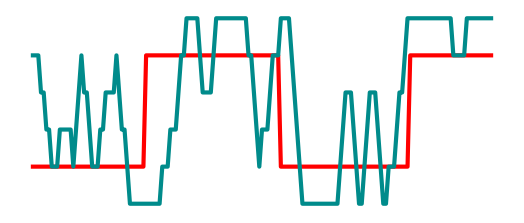

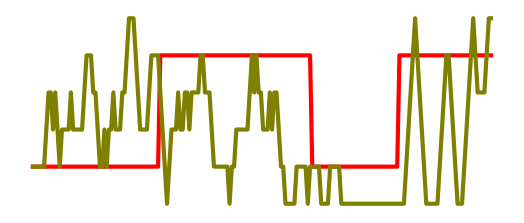

In [22]:
#Sample saline MK801
sample_saline = saline_slices["saline_3"]["C50F5"]
sample_mk801 = mk801_slices["mk801_1"]["C50F5"]

fig, ax = plt.subplots(figsize=(6,3))
c_trueleft = f3b.true_probs(sample_saline)[0].to_list()
c_bactions = f3b.binned_paction(sample_saline)
print(len(c_trueleft), len(c_bactions))
ax.plot(c_trueleft, c="red", linewidth=3)
ax.plot(c_bactions, c="darkcyan", linewidth=3)
plt.axis("off")


fig, ax = plt.subplots(figsize=(6,3))
c_trueleft = f3b.true_probs(sample_mk801)[0].to_list()
c_bactions = f3b.binned_paction(sample_mk801)
print(len(c_trueleft), len(c_bactions))
ax.plot(c_trueleft, c="red", linewidth=3)
ax.plot(c_bactions, c="olive", linewidth=3)
plt.axis("off")

Calculation of pokes, pellets, pokes per pellet, win-stay, and lose-shift metrics.
For documentation and source code of FED3Bandit package, which is used to calculate metrics, please see:

FED3Bandit package documentation: https://fed3bandit.readthedocs.io/en/latest/analysis/fed3live_api.html

FED3Bandit package source code:  https://github.com/AlexLM96/fed3bandit/blob/main/fed3bandit/fed3bandit/fed3bandit.py



In [24]:
# Metrics of the saline group
saline_pellets = {}
saline_pokes = {}
saline_ws = {}
saline_ls = {}
for session in saline_slices:
    #Load data
    c_session = saline_slices[session]
    
    #Calculate metrics
    c_session_pellets = {mouse: [f3b.count_pellets(c_session[mouse])] for mouse in c_session}
    c_session_pokes = {mouse: [f3b.count_pokes(c_session[mouse])] for mouse in c_session}
    c_session_ws = {mouse: [f3b.win_stay(c_session[mouse])] for mouse in c_session}
    c_session_ls = {mouse: [f3b.lose_shift(c_session[mouse])] for mouse in c_session}

    saline_pellets = saline_pellets | c_session_pellets
    saline_pokes = saline_pokes | c_session_pokes
    saline_ws = saline_ws | c_session_ws
    saline_ls = saline_ls | c_session_ls
    
saline_pellets = pd.DataFrame(saline_pellets).T
saline_pokes = pd.DataFrame(saline_pokes).T
saline_ws = pd.DataFrame(saline_ws).T
saline_ls = pd.DataFrame(saline_ls).T
    
# Metrics of the MK801 group
mk801_pellets = {}
mk801_pokes = {}
mk801_ws = {}
mk801_ls = {}
for session in mk801_slices:
    #Load data
    c_session = mk801_slices[session]
    
    #Calculate metrics
    c_session_pellets = {mouse: [f3b.count_pellets(c_session[mouse])] for mouse in c_session}
    c_session_pokes = {mouse: [f3b.count_pokes(c_session[mouse])] for mouse in c_session}
    c_session_ws = {mouse: [f3b.win_stay(c_session[mouse])] for mouse in c_session}
    c_session_ls = {mouse: [f3b.lose_shift(c_session[mouse])] for mouse in c_session}

    mk801_pellets = mk801_pellets | c_session_pellets
    mk801_pokes = mk801_pokes | c_session_pokes
    mk801_ws = mk801_ws | c_session_ws
    mk801_ls = mk801_ls | c_session_ls
    
mk801_pellets = pd.DataFrame(mk801_pellets).T
mk801_pokes = pd.DataFrame(mk801_pokes).T
mk801_ws = pd.DataFrame(mk801_ws).T
mk801_ls = pd.DataFrame(mk801_ls).T

print("All metrics have been successfully calculated")

All metrics have been successfully calculated


Concatenating saline and mk801 groups and preparing for plotting.

In [27]:
# Pellets
all_pellets = pd.concat([saline_pellets, mk801_pellets], axis=1).reset_index()
all_pellets.columns = ["Mouse", "Sal", "MK801"]
m_all_pellets = pd.melt(all_pellets, id_vars="Mouse")
m_all_pellets["variable"] = m_all_pellets["variable"].astype(cat_size_order)
m_all_pellets = m_all_pellets.sort_values(by="variable")

# Pokes
all_pokes = pd.concat([saline_pokes, mk801_pokes], axis=1).reset_index()
all_pokes.columns = ["Mouse", "Sal", "MK801"]
m_all_pokes = pd.melt(all_pokes, id_vars="Mouse")
m_all_pokes["variable"] = m_all_pokes["variable"].astype(cat_size_order)
m_all_pokes = m_all_pokes.sort_values(by="variable")

#Win-stay
all_ws = pd.concat([saline_ws, mk801_ws], axis=1).reset_index()
all_ws.columns = ["Mouse", "Sal", "MK801"]
m_all_ws = pd.melt(all_ws, id_vars="Mouse")
m_all_ws["variable"] = m_all_ws["variable"].astype(cat_size_order)
m_all_ws = m_all_ws.sort_values(by="variable")

#Lose-shift
all_ls = pd.concat([saline_ls, mk801_ls], axis=1).reset_index()
all_ls.columns = ["Mouse", "Sal", "MK801"]
m_all_ls = pd.melt(all_ls, id_vars="Mouse")
m_all_ls["variable"] = m_all_ls["variable"].astype(cat_size_order)
m_all_ls = m_all_ls.sort_values(by="variable")

print("All metrics have been reformatted and are ready for plotting")

All metrics have been reformatted and are ready for plotting


Pellets plot and statistics (Panel 4C)

TtestResult(statistic=0.4052157627858725, pvalue=0.6881941722212075, df=30.0)


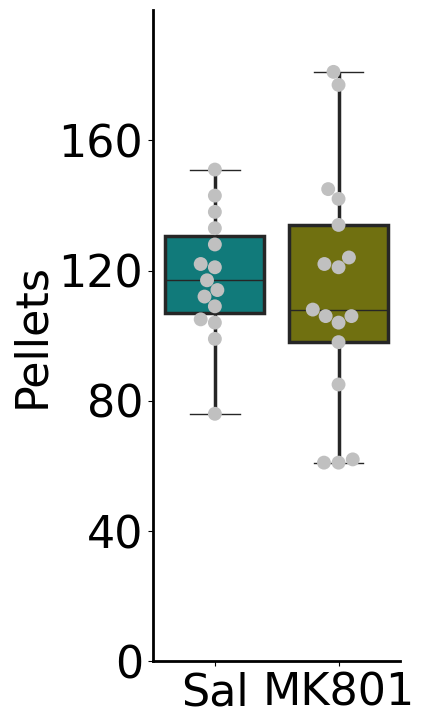

In [28]:
fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="variable", y="value", data=m_all_pellets, palette=[
            "darkcyan", "olive", "salmon"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="variable", y="value", data=m_all_pellets, palette=["silver", "silver", "silver"], s=10)
ax.set_ylabel("Pellets")
ax.set_xlabel("")
sns.despine()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.set_ylim(0,200)
ax.set_yticks(np.arange(0,180,40))

# Run independent ttest
mk801_pellets_ttest = ttest_ind(m_all_pellets["value"][m_all_pellets["variable"]== "Sal"], 
                                m_all_pellets["value"][m_all_pellets["variable"] == "MK801"], nan_policy="omit")

print(mk801_pellets_ttest)

Pokes plot and statistics (Panel 4D)

TtestResult(statistic=-0.5329025599800078, pvalue=0.5980268114306739, df=30.0)


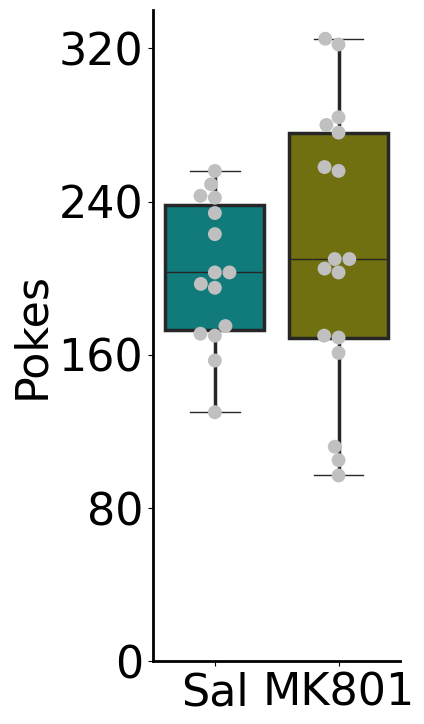

In [29]:
fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="variable", y="value", data=m_all_pokes, palette=[
            "darkcyan", "olive"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="variable", y="value", data=m_all_pokes,
              palette=["silver", "silver"], s=10)
ax.set_ylabel("Pokes")
ax.set_xlabel("")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.set_ylim(0,340)
ax.set_yticks(np.arange(0,340,80))
sns.despine()

# Run independent ttest
mk801_pokes_ttest = ttest_ind(m_all_pokes["value"][m_all_pokes["variable"]== "Sal"], 
                                m_all_pokes["value"][m_all_pokes["variable"] == "MK801"], nan_policy="omit")

print(mk801_pokes_ttest)


Pokes per pellet calculation, plot and statistics (Panel 4E)

TtestResult(statistic=-2.315300793747285, pvalue=0.027619534859861176, df=30.0)


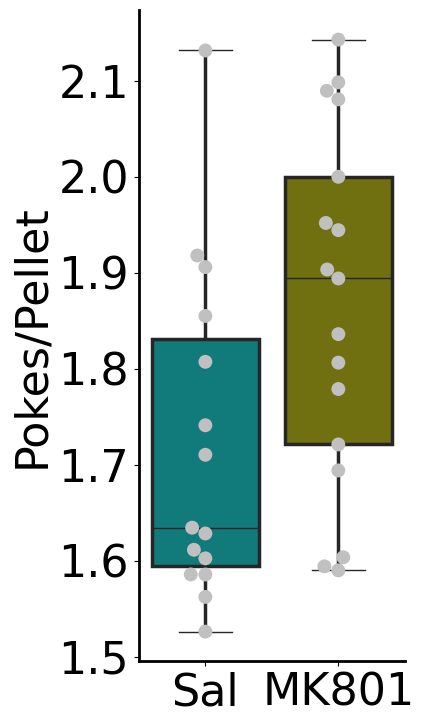

In [37]:
#First we create a copy of the poke dataframe
m_all_ppp = m_all_pokes.copy(deep=True)

#We divide the pokes by the number of pellets
m_all_ppp["value"] /= m_all_pellets["value"]
m_all_ppp = m_all_ppp.rename(columns={"Pokes": "PPP"})
m_all_ppp = m_all_ppp[~m_all_ppp["value"].isna()]

fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="variable", y="value", data=m_all_ppp, palette=[
            "darkcyan", "olive"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="variable", y="value", data=m_all_ppp, palette=["silver", "silver"], s=10)
ax.set_ylabel("Pokes/Pellet")
ax.set_xlabel("")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
#ax.set_ylim(0,340)
#ax.set_yticks(np.arange(0,340,80))
sns.despine()

# Run independent ttest
mk801_pokes_ttest = ttest_ind(m_all_ppp["value"][m_all_ppp["variable"]== "Sal"], 
                                m_all_ppp["value"][m_all_ppp["variable"] == "MK801"], nan_policy="omit")

print(mk801_pokes_ttest)

Calculation of Block change peri-event histogram

In [41]:
#Block change peri-event histogram for MK801 group
m_sal_pehs = {}
for session in saline_slices:
    c_session = saline_slices[session]
    c_pehs = {mouse: f3b.reversal_peh(c_session[mouse], (-10,11)).mean(axis=0) for mouse in c_session}
    c_pehs_df = pd.DataFrame(c_pehs)
    c_pehs_df = c_pehs_df.assign(Trial=np.arange(-10,11), Treatment="Sal")
    m_c_pehs = pd.melt(c_pehs_df, id_vars=["Trial", "Treatment"])
    m_sal_pehs[session] = m_c_pehs

m_sal_pehs = pd.concat(m_sal_pehs.values())

#Block change peri-event histogram for MK801 group
m_mk801_pehs = {}
for session in mk801_slices:
    c_session = mk801_slices[session]
    c_pehs = {mouse: f3b.reversal_peh(c_session[mouse], (-10,11)).mean(axis=0) for mouse in c_session}
    c_pehs_df = pd.DataFrame(c_pehs)
    c_pehs_df = c_pehs_df.assign(Trial=np.arange(-10,11), Treatment="MK801")
    m_c_pehs = pd.melt(c_pehs_df, id_vars=["Trial", "Treatment"])
    m_mk801_pehs[session] = m_c_pehs

m_mk801_pehs = pd.concat(m_mk801_pehs.values())

# Here we pool both groups
m_all_pehs = pd.concat([m_sal_pehs, m_mk801_pehs])

print("All peh were succesfully calculated")

All peh were succesfully calculated


Plot of block change peri-event histogram. Panel 4F

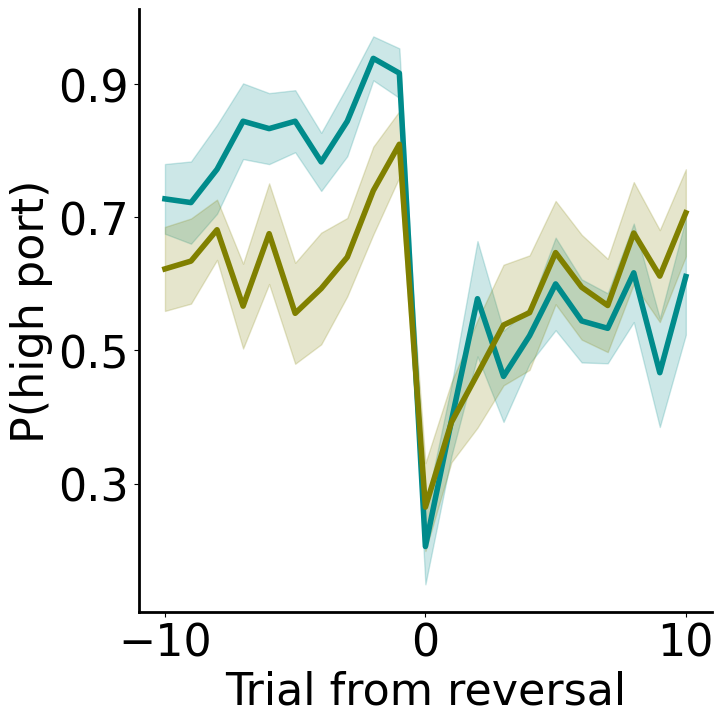

In [42]:
#Panel 4F Left.
fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(x="Trial", y="value", hue="Treatment", data=m_all_pehs, linewidth=4, palette=["darkcyan", "olive"], errorbar="se", legend=False)
ax.set_ylabel("P(high port)")
ax.set_xlabel("Trial from reversal")
ax.set_yticks(np.arange(0.3, 1, 0.2))
sns.despine()
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

TtestResult(statistic=3.6460859070950074, pvalue=0.0009996581105791635, df=30.0)


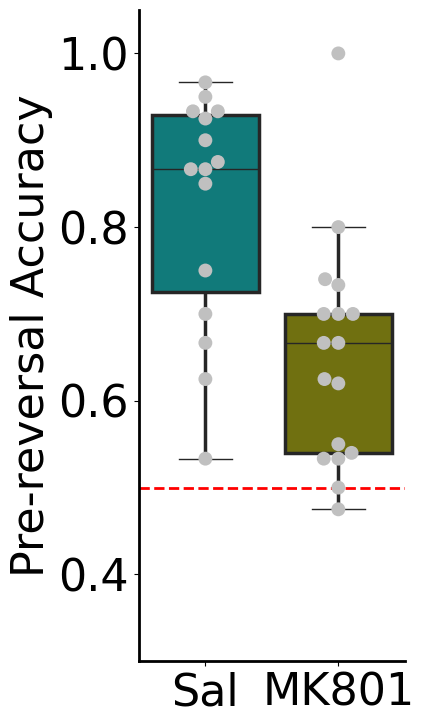

In [51]:
"""Finding the average accuracy prior to the block change."""
all_pre_pehs = m_all_pehs[m_all_pehs["Trial"] < 0]
mean_pre_pehs = all_pre_pehs.groupby(["Treatment", "variable"]).mean().reset_index()
mean_pre_pehs["Treatment"] = mean_pre_pehs["Treatment"].astype(cat_size_order)
mean_pre_pehs = mean_pre_pehs.sort_values(by="Treatment")

#Plot of the average accuracy. Panel 4F Right
fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="Treatment", y="value", data=mean_pre_pehs, palette=[
            "darkcyan", "olive"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="Treatment", y="value", data=mean_pre_pehs, palette=["silver", "silver"], s=10)
ax.axhline(0.5, color="red", linestyle="--")
ax.set_ylabel("Pre-reversal Accuracy")
ax.set_xlabel("")
ax.set_yticks(np.arange(0.4, 1.2, 0.2))
ax.set_ylim(0.3,1.05)
sns.despine()
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

#Statistical test
mk801_rev_ttest = ttest_ind(mean_pre_pehs["value"][mean_pre_pehs["Treatment"]== "Sal"], mean_pre_pehs["value"][mean_pre_pehs["Treatment"] == "MK801"])
print(mk801_rev_ttest)

Plot and statistics of win-stay behavior. Panel 4H

TtestResult(statistic=5.492075298497232, pvalue=5.8068734935029094e-06, df=30.0)


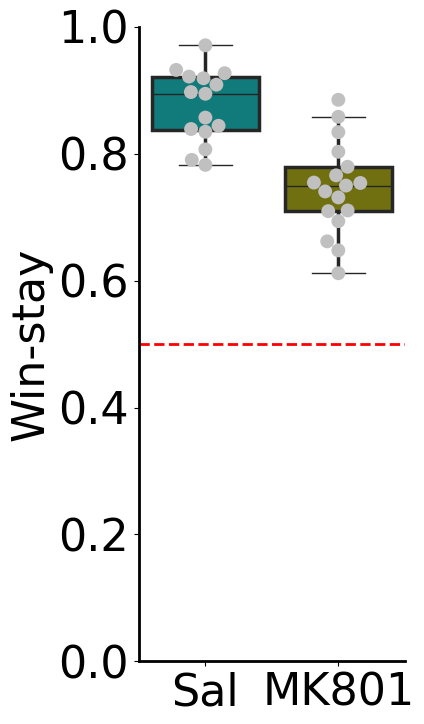

In [50]:
fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="variable", y="value", data=m_all_ws, palette=[
            "darkcyan", "olive"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="variable", y="value", data=m_all_ws, palette=["silver", "silver"], s=10)
ax.set_ylabel("Win-stay")
ax.set_xlabel("")
ax.set_ylim(0,1)
ax.axhline(0.5, color="red", linestyle="--")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
sns.despine()

#Statistical test
mk801_ws_ttest = ttest_ind(m_all_ws["value"][m_all_ws["variable"]== "Sal"], m_all_ws["value"][m_all_ws["variable"] == "MK801"], nan_policy="omit")
print(mk801_ws_ttest)

Fitting the logistic regression to test influence of past rewarded trials on behavior.

In [53]:
saline_pcoeffs = {}
for session in saline_slices:
    c_session = saline_slices[session]
    c_session_sidep = {mouse: f3b.side_prewards(c_session[mouse]) for mouse in c_session}
    c_session_preX = {mouse: f3b.create_X(c_session[mouse], c_session_sidep[mouse], 5)
                      for mouse in c_session_sidep}
    c_session_pcoeffs = {mouse: f3b.logit_regr(c_session_preX[mouse]).params for mouse in c_session_preX}
    saline_pcoeffs = saline_pcoeffs | c_session_pcoeffs
    
saline_pcoeffs = pd.DataFrame(saline_pcoeffs)
saline_pcoeffs = saline_pcoeffs.assign(Treatment="Sal", Trial=np.flip(np.arange(-5, 0, 1)))
m_saline_pcoeffs = pd.melt(saline_pcoeffs, id_vars=["Treatment", "Trial"])

# Count of ws after mk801 injections
mk801_pcoeffs = {}
for session in mk801_slices:
    print(session)
    c_session = mk801_slices[session]
    c_session_sidep = {mouse: f3b.side_prewards(c_session[mouse]) for mouse in c_session}
    c_session_preX = {mouse: f3b.create_X(c_session[mouse], c_session_sidep[mouse], 5)
                      for mouse in c_session_sidep}
    c_session_pcoeffs = {mouse: f3b.logit_regr(c_session_preX[mouse]).params for mouse in c_session_preX}
    mk801_pcoeffs = mk801_pcoeffs | c_session_pcoeffs
    
mk801_pcoeffs = pd.DataFrame(mk801_pcoeffs)
mk801_pcoeffs = mk801_pcoeffs.assign(Treatment="MK801", Trial=np.flip(np.arange(-5, 0, 1)))
m_mk801_pcoeffs = pd.melt(mk801_pcoeffs, id_vars=["Treatment", "Trial"])

m_all_pcoeffs = pd.concat([m_saline_pcoeffs, m_mk801_pcoeffs])

print("Logistic regression for wins was succesffully calculated")

Optimization terminated successfully.
         Current function value: 0.528117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366266
  

Plot and statistics of regression coefficients. Panel 4I

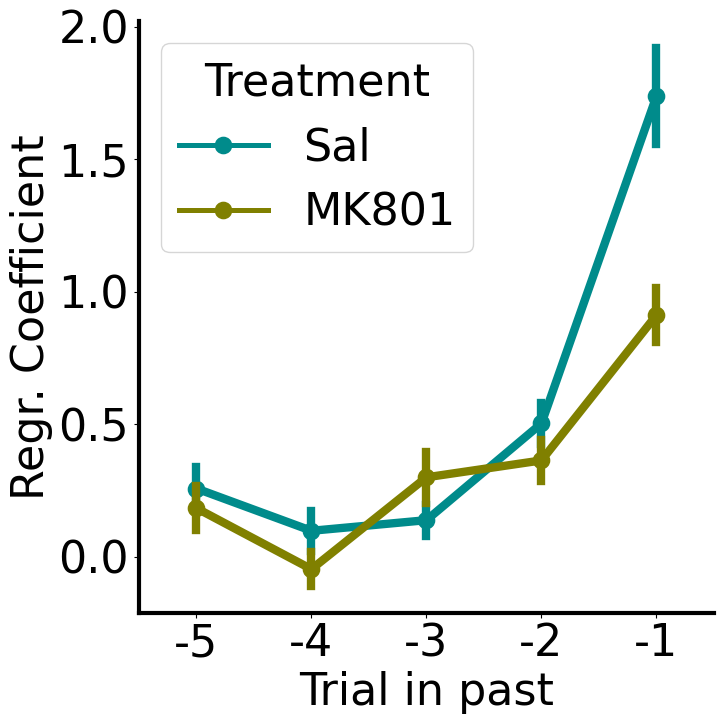

In [54]:
#Panel 4I Left. Plot of regressor coefficients
fig, ax = plt.subplots(figsize=(8, 8))
sns.pointplot(x="Trial", y="value", hue="Treatment", data=m_all_pcoeffs,
              palette=["darkcyan", "olive"], errwidth=3, errorbar="se", markersize=10)
for line in ax.lines:
    line.set_linewidth(6)
ax.set_xlabel("Trial in past")
ax.set_ylabel("Regr. Coefficient")
ax.set_yticks(np.arange(0,2.01,0.5))
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
sns.despine()

TtestResult(statistic=4.1536392205160375, pvalue=0.00024992307778183413, df=30.0)


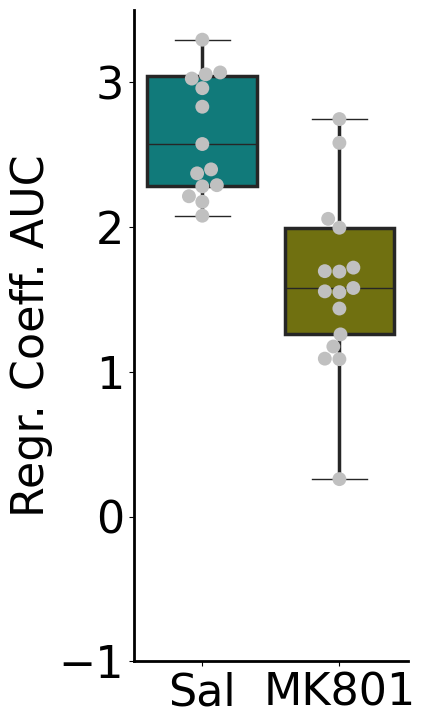

In [55]:
#Plotting of sum of regressor coefficients in both groups
all_paucs = m_all_pcoeffs.groupby(by=["Treatment", "variable"]).sum().reset_index()
all_paucs["Treatment"] = all_paucs["Treatment"].astype(cat_size_order)
all_paucs = all_paucs.sort_values(by="Treatment")

fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="Treatment", y="value", data=all_paucs, palette=[
            "darkcyan", "olive"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="Treatment", y="value", data=all_paucs,
              palette=["silver", "silver"], s=10)
ax.set_ylabel("Regr. Coeff. AUC")
ax.set_xlabel("")
ax.set_yticks(np.arange(-1,4,1))
ax.set_ylim(-1,3.5)
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
sns.despine()

#Statistical test
mk801_pauc_ttest = ttest_ind(all_paucs["value"][all_paucs["Treatment"]== "Sal"], all_paucs["value"][all_paucs["Treatment"] == "MK801"])
print(mk801_pauc_ttest)

Lose-shift

TtestResult(statistic=21.233775406653628, pvalue=1.25663839835834e-19, df=30.0)


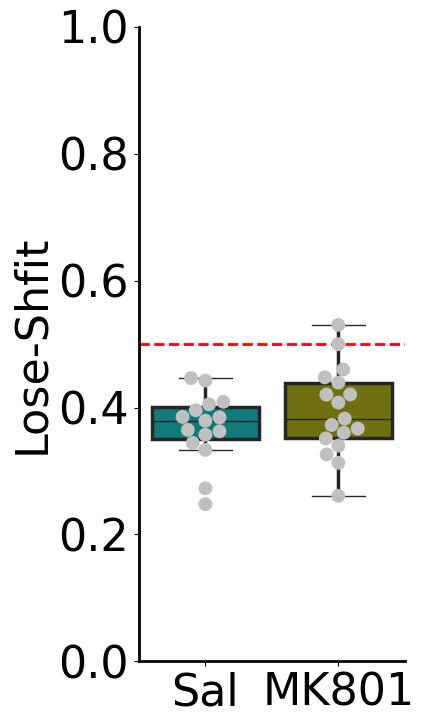

In [57]:
fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="variable", y="value", data=m_all_ls, palette=[
            "darkcyan", "olive"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="variable", y="value", data=m_all_ls, palette=["silver", "silver"], s=10)
ax.set_ylabel("Lose-Shfit")
ax.set_xlabel("")
ax.set_ylim(0,1)
ax.axhline(0.5, color="red", linestyle="--")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
sns.despine()

#Statistical test
mk801_ls_ttest = ttest_ind(m_all_ws["value"][m_all_ls["variable"]== "Sal"], m_all_ls["value"][m_all_ls["variable"] == "MK801"], nan_policy="omit")
print(mk801_ls_ttest)

Calculating log ress for losses

In [59]:
saline_ncoeffs = {}
for session in saline_slices:
    c_session = saline_slices[session]
    c_session_siden = {mouse: f3b.side_nrewards(c_session[mouse]) for mouse in c_session}
    c_session_prenX = {mouse: f3b.create_X(c_session[mouse], c_session_siden[mouse], 5)
                      for mouse in c_session_siden}
    c_session_ncoeffs = {mouse: f3b.logit_regr(c_session_prenX[mouse]).params for mouse in c_session_prenX}
    saline_ncoeffs = saline_ncoeffs | c_session_ncoeffs
    
saline_ncoeffs = pd.DataFrame(saline_ncoeffs)
saline_ncoeffs = saline_ncoeffs.assign(Treatment="Sal", Trial=np.flip(np.arange(-5, 0, 1)))
m_saline_ncoeffs = pd.melt(saline_ncoeffs, id_vars=["Treatment", "Trial"])

# Count of ws after mk801 injections
mk801_ncoeffs = {}
for session in mk801_slices:
    print(session)
    c_session = mk801_slices[session]
    c_session_siden = {mouse: f3b.side_nrewards(c_session[mouse]) for mouse in c_session}
    c_session_prenX = {mouse: f3b.create_X(c_session[mouse], c_session_siden[mouse], 5)
                      for mouse in c_session_siden}
    c_session_ncoeffs = {mouse: f3b.logit_regr(c_session_prenX[mouse]).params for mouse in c_session_prenX}
    mk801_ncoeffs = mk801_ncoeffs | c_session_ncoeffs
    
mk801_ncoeffs = pd.DataFrame(mk801_ncoeffs)
mk801_ncoeffs = mk801_ncoeffs.assign(Treatment="MK801", Trial=np.flip(np.arange(-5, 0, 1)))
m_mk801_ncoeffs = pd.melt(mk801_ncoeffs, id_vars=["Treatment", "Trial"])

m_all_ncoeffs = pd.concat([m_saline_ncoeffs, m_mk801_ncoeffs])

all_naucs = m_all_ncoeffs.groupby(by=["Treatment", "variable"]).sum().reset_index()
all_naucs["Treatment"] = all_naucs["Treatment"].astype(cat_size_order)
all_naucs = all_naucs.sort_values(by="Treatment")

print("Logistic regression for wins was succesffully calculated")





Optimization terminated successfully.
         Current function value: 0.659649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679944
  

Plot and statistics of regression coefficients. Panel 4M


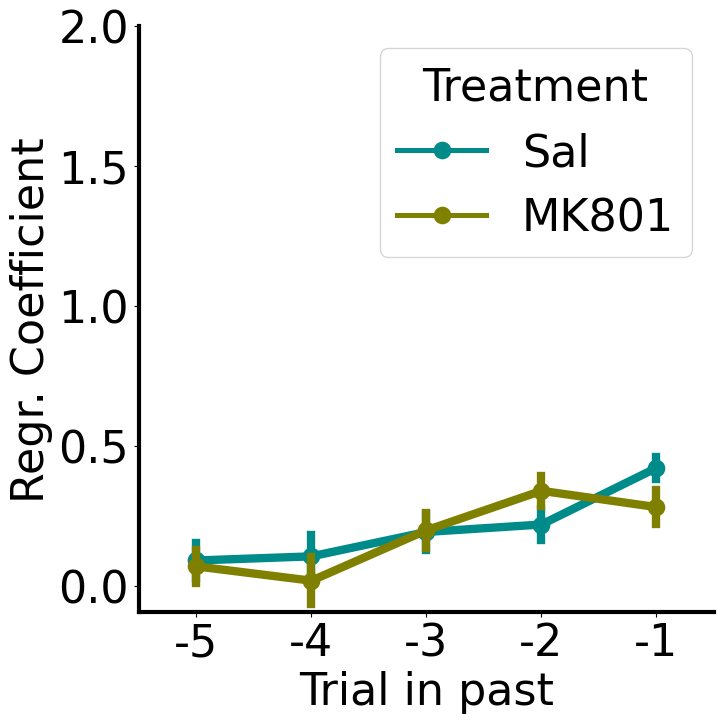

In [60]:
#Panel 4M Left. Plot of regressor coefficients
fig, ax = plt.subplots(figsize=(8, 8))
sns.pointplot(x="Trial", y="value", hue="Treatment", data=m_all_ncoeffs,
              palette=["darkcyan", "olive"], errwidth=3, errorbar="se", markersize=10)
for line in ax.lines:
    line.set_linewidth(6)
ax.set_xlabel("Trial in past")
ax.set_ylabel("Regr. Coefficient")
ax.set_yticks(np.arange(0,2.01,0.5))
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
sns.despine()

TtestResult(statistic=0.4728098438907627, pvalue=0.6397707718851505, df=30.0)


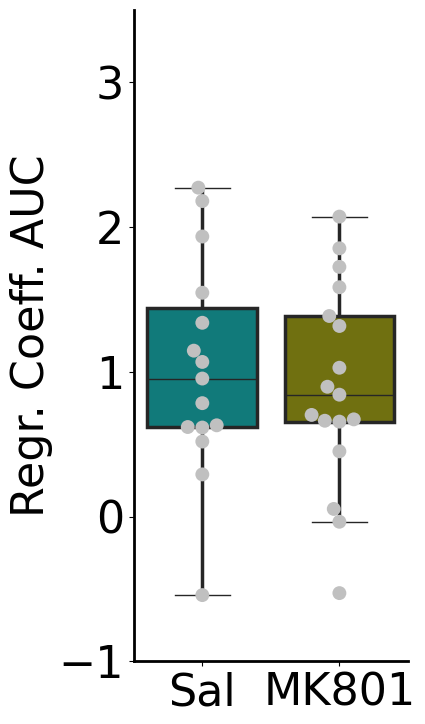

In [62]:
fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="Treatment", y="value", data=all_naucs, palette=[
            "darkcyan", "olive"], boxprops={"linewidth": 2.5}, whiskerprops={"linewidth": 2.5})
sns.swarmplot(x="Treatment", y="value", data=all_naucs, palette=["silver", "silver"], s=10)
ax.set_ylabel("Regr. Coeff. AUC")
ax.set_xlabel("")
ax.set_yticks(np.arange(-1,4,1))
ax.set_ylim(-1,3.5)
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
sns.despine()

# Independent ttest
mk801_nauc_ttest = ttest_ind(all_naucs["value"][all_naucs["Treatment"]== "Sal"], all_naucs["value"][all_naucs["Treatment"] == "MK801"])
print(mk801_nauc_ttest)